# Synthetic Difference-in-Differences: Foundations

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Chapter 25 | Notebook 1 of 3**

This notebook introduces the Synthetic Difference-in-Differences (SDID) method, which
elegantly combines the best features of both Difference-in-Differences (DiD) and
Synthetic Control (SC) methods.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

# Additional imports for this notebook
from scipy.optimize import fmin_slsqp
from functools import partial

---

## 1. Intuition {#intuition}

### The Best of Both Worlds

Consider the challenge of estimating treatment effects in panel data:

**Difference-in-Differences (DiD):**
- Uses all control units equally
- Relies on parallel trends assumption
- Simple, but sensitive to trends mismatch

**Synthetic Control (SC):**
- Weights control units to match pre-treatment trends
- Excellent pre-treatment fit
- No time-period balancing

**Synthetic DiD (SDID):**
- Weights *both* units AND time periods
- Unit weights ensure good pre-treatment fit
- Time weights ensure good "parallel trends" matching
- Combines strengths of both methods

> **Key Insight**: SDID asks: "Which control units look most like treated units?"
> AND "Which pre-treatment periods are most informative about counterfactual trends?"

### The Block Matrix Representation

Panel data can be organized into a **block matrix** structure:

$$Y = \begin{bmatrix} Y_{co}^{pre} & Y_{co}^{post} \\ Y_{tr}^{pre} & Y_{tr}^{post} \end{bmatrix}$$

Where:
- $Y_{co}^{pre}$: Control units, pre-treatment periods ($N_{co} \times T_{pre}$)
- $Y_{co}^{post}$: Control units, post-treatment periods ($N_{co} \times T_{post}$)
- $Y_{tr}^{pre}$: Treated units, pre-treatment periods ($N_{tr} \times T_{pre}$)
- $Y_{tr}^{post}$: Treated units, post-treatment periods ($N_{tr} \times T_{post}$)

This organization reveals the fundamental estimation problem: we observe all four blocks,
but the counterfactual (what $Y_{tr}^{post}$ would have been without treatment) is missing.

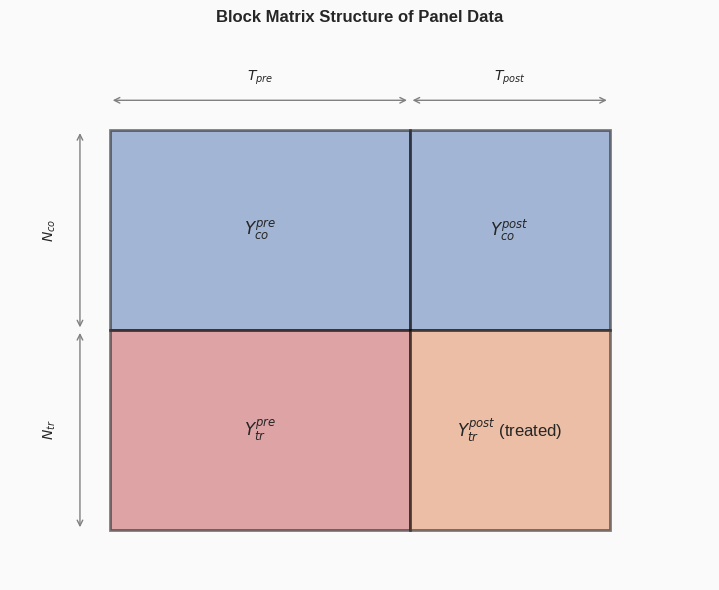

In [2]:
# Visualize the block matrix structure
fig, ax = plt.subplots(figsize=(8, 6))

# Create block matrix visualization
blocks = [
    # (x, y, width, height, color, label)
    (0, 2, 3, 2, COLORS['blue'], r'$Y_{co}^{pre}$'),
    (3, 2, 2, 2, COLORS['blue'], r'$Y_{co}^{post}$'),
    (0, 0, 3, 2, COLORS['red'], r'$Y_{tr}^{pre}$'),
    (3, 0, 2, 2, COLORS['orange'], r'$Y_{tr}^{post}$ (treated)'),
]

for x, y, w, h, color, label in blocks:
    rect = plt.Rectangle((x, y), w, h, facecolor=color, edgecolor='black', 
                          alpha=0.5, linewidth=2)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, label, ha='center', va='center', fontsize=12)

# Add dimension annotations
ax.annotate('', xy=(0, 4.3), xytext=(3, 4.3), 
            arrowprops=dict(arrowstyle='<->', color='gray'))
ax.text(1.5, 4.5, r'$T_{pre}$', ha='center', fontsize=10)

ax.annotate('', xy=(3, 4.3), xytext=(5, 4.3),
            arrowprops=dict(arrowstyle='<->', color='gray'))
ax.text(4, 4.5, r'$T_{post}$', ha='center', fontsize=10)

ax.annotate('', xy=(-0.3, 2), xytext=(-0.3, 4),
            arrowprops=dict(arrowstyle='<->', color='gray'))
ax.text(-0.6, 3, r'$N_{co}$', ha='center', va='center', fontsize=10, rotation=90)

ax.annotate('', xy=(-0.3, 0), xytext=(-0.3, 2),
            arrowprops=dict(arrowstyle='<->', color='gray'))
ax.text(-0.6, 1, r'$N_{tr}$', ha='center', va='center', fontsize=10, rotation=90)

ax.set_xlim(-1, 6)
ax.set_ylim(-0.5, 5)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Block Matrix Structure of Panel Data', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---

## 2. Formal Treatment {#formal}

### 2.1 Standard DiD Estimator

The classic DiD estimator with equal weighting:

$$\hat{\tau}^{did} = \left( \bar{Y}_{tr}^{post} - \bar{Y}_{tr}^{pre} \right) - \left( \bar{Y}_{co}^{post} - \bar{Y}_{co}^{pre} \right)$$

This can be written as a **weighted double-difference**:

$$\hat{\tau}^{did} = \sum_{i,t} D_{it} Y_{it} \cdot w_i^{did} \cdot \lambda_t^{did}$$

Where:
- $w_i^{did} = \frac{1}{N_{co}}$ for control units (equal weight)
- $\lambda_t^{did} = \frac{1}{T_{pre}}$ for pre-periods, $\frac{1}{T_{post}}$ for post-periods

### 2.2 Synthetic Control Estimator

SC finds optimal unit weights to match pre-treatment trends:

$$\hat{\tau}^{sc} = \bar{Y}_{tr}^{post} - \sum_{i \in co} \hat{w}_i^{sc} \bar{Y}_i^{post}$$

Where weights $\hat{w}^{sc}$ minimize pre-treatment MSE:

$$\hat{w}^{sc} = \arg\min_w \sum_{t \leq T_0} \left( Y_{tr,t} - \sum_{i \in co} w_i Y_{i,t} \right)^2$$

Subject to: $\sum_i w_i = 1$, $w_i \geq 0$

**Key limitation**: SC uses only post-treatment outcomes, ignoring pre/post change structure.

### 2.3 Synthetic Difference-in-Differences

SDID combines both approaches via a **weighted two-way fixed effects** regression:

$$\hat{\tau}^{sdid} = \underset{\mu, \alpha, \beta, \tau}{\arg\min} \left\{ \sum_{i,t} \left( Y_{it} - \mu - \alpha_i - \beta_t - \tau \cdot D_{it} \right)^2 \hat{w}_i \hat{\lambda}_t \right\}$$

Where:
- $\hat{w}_i$: **Unit weights** (like SC, match pre-treatment trends)
- $\hat{\lambda}_t$: **Time weights** (balance pre/post periods for controls)
- $\alpha_i$: Unit fixed effects
- $\beta_t$: Time fixed effects
- $D_{it}$: Treatment indicator (1 if treated unit in post period)

**The key innovation**: SDID estimates both unit weights (like SC) AND time weights
(novel contribution), then runs weighted TWFE.

### 2.4 Unit Weight Estimation

SDID unit weights solve a modified SC problem with an **intercept** and **L2 penalty**:

$$\hat{w}^{sdid} = \arg\min_{w_0, w} \sum_{t \leq T_0} \left( w_0 + \sum_{i \in co} w_i Y_{it} - \bar{Y}_{tr,t} \right)^2 + \zeta^2 T_{pre} \|w\|_2^2$$

Subject to: $\sum_{i} w_i = 1$, $w_i \geq 0$

Key differences from SC:
1. **Intercept $w_0$**: Allows level shift, reducing sensitivity to scale
2. **L2 penalty**: Regularization parameter $\zeta$ prevents overfitting

The regularization parameter is calibrated as:
$$\zeta = (N_{tr} \cdot T_{post})^{1/4} \cdot \hat{\sigma}(\Delta_{it})$$

Where $\hat{\sigma}(\Delta_{it})$ is the standard deviation of first-differences for control units.

### 2.5 Time Weight Estimation

Time weights balance the pre-treatment periods to match post-treatment periods for controls:

$$\hat{\lambda}^{sdid} = \arg\min_{\lambda_0, \lambda} \sum_{i \in co} \left( \lambda_0 + \sum_{t \leq T_0} \lambda_t Y_{it} - \frac{1}{T_{post}}\sum_{t > T_0} Y_{it} \right)^2$$

Subject to: $\sum_t \lambda_t = 1$, $\lambda_t \geq 0$

**Intuition**: Find pre-treatment periods that best predict post-treatment outcomes for controls.
This ensures DiD comparison uses comparable time periods.

---

## 3. Numeric Demonstration {#numeric}

### Proposition 99: California's Tobacco Control Program

We use the classic Proposition 99 dataset from Abadie et al. (2010):
- **Treated**: California (passed tobacco tax in 1988)
- **Controls**: 38 other US states
- **Outcome**: Per-capita cigarette sales
- **Pre-period**: 1970-1988
- **Post-period**: 1989-2000

In [3]:
# Load the smoking data
cigar = load_facure_data("smoking.csv")

print(f"Dataset shape: {cigar.shape}")
print(f"States: {cigar['state'].nunique()}")
print(f"Years: {cigar['year'].min()} - {cigar['year'].max()}")
print(f"\nColumns: {cigar.columns.tolist()}")

# Show only the columns we'll use (state, year, cigsale)
cigar[['state', 'year', 'cigsale']].head(10)

Dataset shape: (1209, 9)
States: 39
Years: 1970 - 2000

Columns: ['state', 'year', 'cigsale', 'lnincome', 'beer', 'age15to24', 'retprice', 'california', 'after_treatment']


,state,year,cigsale
0,1,1970,89.8000
1,1,1971,95.4000
2,1,1972,101.1000
3,1,1973,102.9000
4,1,1974,108.2000
5,1,1975,111.7000
6,1,1976,116.2000
7,1,1977,117.1000
8,1,1978,123.0000
9,1,1979,121.4000


In [4]:
# Identify California (state 3)
calif_state = 3
treatment_year = 1989

# Create treatment indicators
cigar['treated'] = (cigar['state'] == calif_state).astype(int)
cigar['post'] = (cigar['year'] >= treatment_year).astype(int)
cigar['D'] = cigar['treated'] * cigar['post']

print(f"California observations: {cigar['treated'].sum()}")
print(f"Control observations: {(~cigar['treated'].astype(bool)).sum()}")

California observations: 31
Control observations: 1178


In [5]:
# Create the block matrix structure
T_pre = (cigar['year'] < treatment_year).sum() // cigar['state'].nunique()
T_post = (cigar['year'] >= treatment_year).sum() // cigar['state'].nunique()
N_co = cigar['state'].nunique() - 1
N_tr = 1

print(f"Block matrix dimensions:")
print(f"  Pre-treatment periods (T_pre): {T_pre}")
print(f"  Post-treatment periods (T_post): {T_post}")
print(f"  Control units (N_co): {N_co}")
print(f"  Treated units (N_tr): {N_tr}")

Block matrix dimensions:
  Pre-treatment periods (T_pre): 19
  Post-treatment periods (T_post): 12
  Control units (N_co): 38
  Treated units (N_tr): 1


In [6]:
# Pivot to wide format for block operations
Y_wide = cigar.pivot(index='state', columns='year', values='cigsale')

# Extract blocks
pre_years = [y for y in Y_wide.columns if y < treatment_year]
post_years = [y for y in Y_wide.columns if y >= treatment_year]

Y_co_pre = Y_wide.loc[Y_wide.index != calif_state, pre_years].values
Y_co_post = Y_wide.loc[Y_wide.index != calif_state, post_years].values
Y_tr_pre = Y_wide.loc[calif_state, pre_years].values.reshape(1, -1)
Y_tr_post = Y_wide.loc[calif_state, post_years].values.reshape(1, -1)

print(f"Y_co_pre shape: {Y_co_pre.shape}")
print(f"Y_co_post shape: {Y_co_post.shape}")
print(f"Y_tr_pre shape: {Y_tr_pre.shape}")
print(f"Y_tr_post shape: {Y_tr_post.shape}")

Y_co_pre shape: (38, 19)
Y_co_post shape: (38, 12)
Y_tr_pre shape: (1, 19)
Y_tr_post shape: (1, 12)


### Standard DiD Estimate

In [7]:
# Standard DiD: equal weighting
did_treated_change = Y_tr_post.mean() - Y_tr_pre.mean()
did_control_change = Y_co_post.mean() - Y_co_pre.mean()
tau_did = did_treated_change - did_control_change

print(f"DiD Estimate:")
print(f"  Treated change (post - pre): {did_treated_change:.2f}")
print(f"  Control change (post - pre): {did_control_change:.2f}")
print(f"  DiD effect (tau_did): {tau_did:.2f}")

DiD Estimate:
  Treated change (post - pre): -55.86
  Control change (post - pre): -28.51
  DiD effect (tau_did): -27.35


### Synthetic Control Estimate

In [8]:
def sc_loss(W, X, y):
    """MSE loss for synthetic control weights."""
    return np.sqrt(np.mean((y - X @ W)**2))

def get_sc_weights(X, y):
    """Estimate synthetic control weights.
    
    Parameters
    ----------
    X : ndarray (T_pre, N_co)
        Control unit outcomes in pre-period
    y : ndarray (T_pre,)
        Treated unit outcomes in pre-period
        
    Returns
    -------
    W : ndarray (N_co,)
        Optimal weights for control units
    """
    n_controls = X.shape[1]
    w_start = np.ones(n_controls) / n_controls
    
    weights = fmin_slsqp(
        partial(sc_loss, X=X, y=y),
        w_start,
        f_eqcons=lambda w: np.sum(w) - 1,
        bounds=[(0.0, 1.0)] * n_controls,
        disp=False
    )
    return weights

# Estimate SC weights
# X is (T_pre, N_co), y is (T_pre,)
X_sc = Y_co_pre.T  # (T_pre, N_co)
y_sc = Y_tr_pre.flatten()  # (T_pre,)

w_sc = get_sc_weights(X_sc, y_sc)

print(f"SC Weights (top 10 by magnitude):")
state_names = Y_wide.index[Y_wide.index != calif_state].tolist()
weight_df = pd.DataFrame({'state': state_names, 'weight': w_sc})
print(weight_df.nlargest(10, 'weight').to_string(index=False))

SC Weights (top 10 by magnitude):
 state  weight
    34  0.3939
    19  0.2318
    21  0.2049
     5  0.1091
    22  0.0454
     4  0.0148
     6  0.0000
     9  0.0000
    20  0.0000
    12  0.0000


In [9]:
# SC estimate: compare treated post to synthetic post
Y_synth_post = Y_co_post.T @ w_sc  # (T_post,)
tau_sc = Y_tr_post.mean() - Y_synth_post.mean()

print(f"SC Estimate:")
print(f"  California post-treatment mean: {Y_tr_post.mean():.2f}")
print(f"  Synthetic California post-treatment mean: {Y_synth_post.mean():.2f}")
print(f"  SC effect (tau_sc): {tau_sc:.2f}")

SC Estimate:
  California post-treatment mean: 60.35
  Synthetic California post-treatment mean: 79.86
  SC effect (tau_sc): -19.51


### Comparison: DiD vs SC

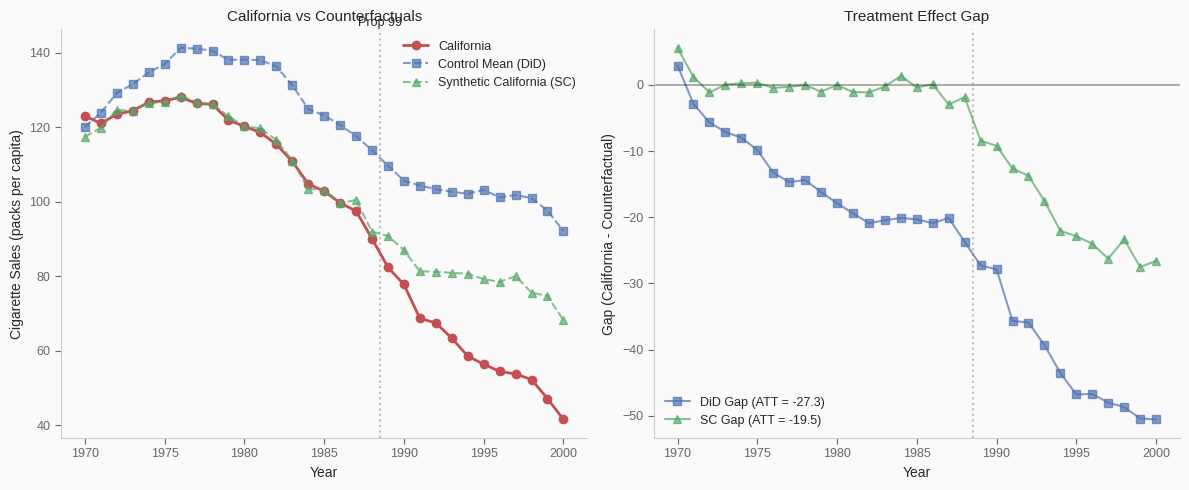


Key Insight: SC provides better pre-treatment fit (gap ≈ 0),
but DiD explicitly models the change structure.


In [10]:
# Visualize the three counterfactuals
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

years = np.array(pre_years + post_years)
calif_series = np.concatenate([Y_tr_pre.flatten(), Y_tr_post.flatten()])
control_mean = np.concatenate([Y_co_pre.mean(axis=0), Y_co_post.mean(axis=0)])
synth_calif = np.concatenate([X_sc @ w_sc, Y_synth_post])

# Left: Raw series
ax = axes[0]
ax.plot(years, calif_series, 'o-', color=COLORS['red'], label='California', linewidth=2)
ax.plot(years, control_mean, 's--', color=COLORS['blue'], label='Control Mean (DiD)', alpha=0.7)
ax.plot(years, synth_calif, '^--', color=COLORS['green'], label='Synthetic California (SC)', alpha=0.7)
ax.axvline(treatment_year - 0.5, color='gray', linestyle=':', alpha=0.5)
ax.text(treatment_year - 0.5, ax.get_ylim()[1], 'Prop 99', ha='center', va='bottom', fontsize=9)
ax.set_xlabel('Year')
ax.set_ylabel('Cigarette Sales (packs per capita)')
ax.set_title('California vs Counterfactuals')
ax.legend(loc='upper right')
apply_tufte_style(ax)

# Right: Gap (treatment effect over time)
ax = axes[1]
gap_did = calif_series - control_mean
gap_sc = calif_series - synth_calif

ax.plot(years, gap_did, 's-', color=COLORS['blue'], label=f'DiD Gap (ATT = {tau_did:.1f})', alpha=0.7)
ax.plot(years, gap_sc, '^-', color=COLORS['green'], label=f'SC Gap (ATT = {tau_sc:.1f})', alpha=0.7)
ax.axvline(treatment_year - 0.5, color='gray', linestyle=':', alpha=0.5)
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Year')
ax.set_ylabel('Gap (California - Counterfactual)')
ax.set_title('Treatment Effect Gap')
ax.legend(loc='lower left')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

print(f"\nKey Insight: SC provides better pre-treatment fit (gap ≈ 0),")
print(f"but DiD explicitly models the change structure.")

---

## 4. Implementation {#implementation}

### SDID as Weighted TWFE

The key insight of SDID: use SC-style unit weights + novel time weights, then run TWFE.

In [11]:
def compute_zeta(Y_co_pre, N_tr, T_post):
    """Compute regularization parameter for SDID unit weights.
    
    zeta = (N_tr * T_post)^(1/4) * std(first_differences)
    """
    # First differences for control units
    delta = np.diff(Y_co_pre, axis=1)  # (N_co, T_pre-1)
    sigma_delta = np.std(delta)
    
    zeta = (N_tr * T_post) ** 0.25 * sigma_delta
    return zeta

zeta = compute_zeta(Y_co_pre, N_tr, T_post)
print(f"Regularization parameter zeta: {zeta:.4f}")

Regularization parameter zeta: 10.2188


In [12]:
def sdid_unit_loss(params, X, y, zeta, T_pre):
    """Loss function for SDID unit weights with intercept and L2 penalty.
    
    Parameters
    ----------
    params : ndarray (N_co + 1,)
        First element is intercept w0, rest are weights
    X : ndarray (T_pre, N_co)
        Control outcomes in pre-period
    y : ndarray (T_pre,)
        Treated outcomes in pre-period  
    zeta : float
        Regularization parameter
    T_pre : int
        Number of pre-treatment periods
    """
    w0 = params[0]  # intercept
    w = params[1:]  # unit weights
    
    # Prediction error
    pred = w0 + X @ w
    mse = np.mean((y - pred)**2)
    
    # L2 penalty (scaled by T_pre as in paper)
    penalty = zeta**2 * T_pre * np.sum(w**2)
    
    return mse + penalty

def get_sdid_unit_weights(X, y, zeta, T_pre):
    """Estimate SDID unit weights with intercept and L2 penalty."""
    n_controls = X.shape[1]
    
    # Initial: intercept=0, equal weights
    params_start = np.concatenate([[0], np.ones(n_controls) / n_controls])
    
    # Constraints: weights sum to 1, weights >= 0 (intercept unconstrained)
    def weight_sum_constraint(params):
        return np.sum(params[1:]) - 1
    
    # Bounds: intercept unbounded, weights in [0, 1]
    bounds = [(None, None)] + [(0.0, 1.0)] * n_controls
    
    result = fmin_slsqp(
        partial(sdid_unit_loss, X=X, y=y, zeta=zeta, T_pre=T_pre),
        params_start,
        f_eqcons=weight_sum_constraint,
        bounds=bounds,
        disp=False
    )
    
    w0 = result[0]
    w = result[1:]
    return w0, w

# Estimate SDID unit weights
w0_sdid, w_sdid = get_sdid_unit_weights(X_sc, y_sc, zeta, T_pre)

print(f"SDID Unit Weights:")
print(f"  Intercept (w0): {w0_sdid:.4f}")
print(f"  Number of non-zero weights: {np.sum(w_sdid > 0.01)}")

# Compare to SC weights
print(f"\nTop 5 states by SDID weight:")
sdid_weight_df = pd.DataFrame({'state': state_names, 'sdid_weight': w_sdid, 'sc_weight': w_sc})
print(sdid_weight_df.nlargest(5, 'sdid_weight').to_string(index=False))

SDID Unit Weights:
  Intercept (w0): -21.3433
  Number of non-zero weights: 37

Top 5 states by SDID weight:
 state  sdid_weight  sc_weight
    22       0.0698     0.0454
    21       0.0584     0.2049
    24       0.0482     0.0000
     4       0.0367     0.0148
     6       0.0364     0.0000


In [13]:
def sdid_time_loss(params, Y_co, T_pre):
    """Loss function for SDID time weights.
    
    Find pre-period weights that predict post-period mean for controls.
    """
    lambda0 = params[0]  # intercept
    lam = params[1:]  # time weights
    
    # Y_co: (N_co, T_total)
    Y_co_pre = Y_co[:, :T_pre]
    Y_co_post = Y_co[:, T_pre:]
    
    # For each control unit, predict post-mean from weighted pre-period
    # pred_i = lambda0 + sum_t(lambda_t * Y_it_pre)
    pred = lambda0 + Y_co_pre @ lam  # (N_co,)
    target = Y_co_post.mean(axis=1)  # (N_co,)
    
    return np.mean((target - pred)**2)

def get_sdid_time_weights(Y_co, T_pre):
    """Estimate SDID time weights."""
    # Initial: intercept=0, equal weights
    params_start = np.concatenate([[0], np.ones(T_pre) / T_pre])
    
    def time_sum_constraint(params):
        return np.sum(params[1:]) - 1
    
    bounds = [(None, None)] + [(0.0, 1.0)] * T_pre
    
    result = fmin_slsqp(
        partial(sdid_time_loss, Y_co=Y_co, T_pre=T_pre),
        params_start,
        f_eqcons=time_sum_constraint,
        bounds=bounds,
        disp=False
    )
    
    lambda0 = result[0]
    lam = result[1:]
    return lambda0, lam

# Stack controls for time weight estimation
Y_co_full = np.hstack([Y_co_pre, Y_co_post])  # (N_co, T_total)

lambda0_sdid, lambda_sdid = get_sdid_time_weights(Y_co_full, T_pre)

print(f"SDID Time Weights:")
print(f"  Intercept (lambda0): {lambda0_sdid:.4f}")
print(f"  Number of non-zero time weights: {np.sum(lambda_sdid > 0.01)}")

SDID Time Weights:
  Intercept (lambda0): -15.0239
  Number of non-zero time weights: 3


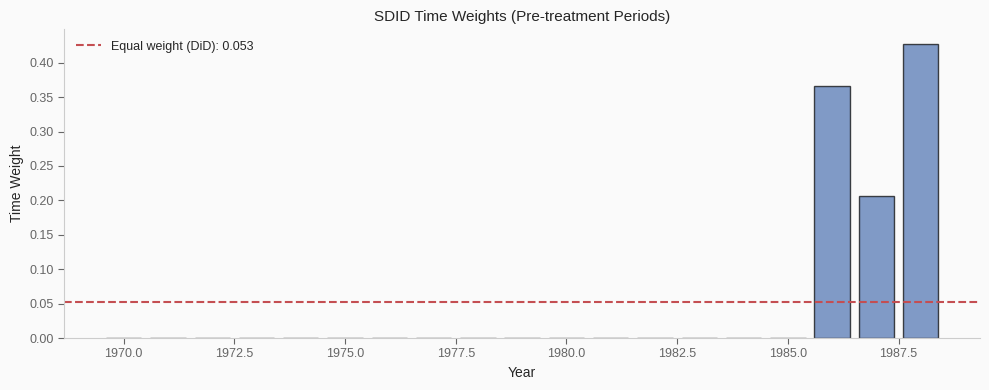


Note: Time weights concentrate on periods most predictive of post-treatment.
This ensures the DiD comparison uses informative pre-periods.


In [14]:
# Visualize time weights
fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(pre_years, lambda_sdid, color=COLORS['blue'], alpha=0.7, edgecolor='black')
ax.axhline(1/T_pre, color=COLORS['red'], linestyle='--', 
           label=f'Equal weight (DiD): {1/T_pre:.3f}')
ax.set_xlabel('Year')
ax.set_ylabel('Time Weight')
ax.set_title('SDID Time Weights (Pre-treatment Periods)')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

print(f"\nNote: Time weights concentrate on periods most predictive of post-treatment.")
print(f"This ensures the DiD comparison uses informative pre-periods.")

### SDID Estimate via Weighted Double-Difference

In [15]:
def sdid_estimate(Y_tr_pre, Y_tr_post, Y_co_pre, Y_co_post, w, lam):
    """Compute SDID estimate using weighted double-difference formula.
    
    tau_sdid = (Y_tr_post_mean - w'Y_co_post_mean) - (lambda'Y_tr_pre - lambda'(w'Y_co_pre))
    
    This is the "basic" SDID estimator from Arkhangelsky et al. (2021).
    """
    # Post-period comparison (weighted by unit weights)
    Y_tr_post_mean = Y_tr_post.mean()
    Y_co_post_weighted = (Y_co_post.T @ w).mean()  # w-weighted control post mean
    
    # Pre-period comparison (weighted by time weights)
    Y_tr_pre_weighted = Y_tr_pre.flatten() @ lam  # lambda-weighted treated pre
    Y_co_pre_weighted = (Y_co_pre.T @ w) @ lam  # both weights for controls pre
    
    # Double difference
    tau = (Y_tr_post_mean - Y_co_post_weighted) - (Y_tr_pre_weighted - Y_co_pre_weighted)
    
    return tau

tau_sdid = sdid_estimate(Y_tr_pre, Y_tr_post, Y_co_pre, Y_co_post, w_sdid, lambda_sdid)

print(f"\n" + "="*50)
print(f"COMPARISON OF ESTIMATORS")
print(f"="*50)
print(f"DiD estimate:  {tau_did:.2f} packs/capita")
print(f"SC estimate:   {tau_sc:.2f} packs/capita")
print(f"SDID estimate: {tau_sdid:.2f} packs/capita")
print(f"="*50)


COMPARISON OF ESTIMATORS
DiD estimate:  -27.35 packs/capita
SC estimate:   -19.51 packs/capita
SDID estimate: -17.98 packs/capita


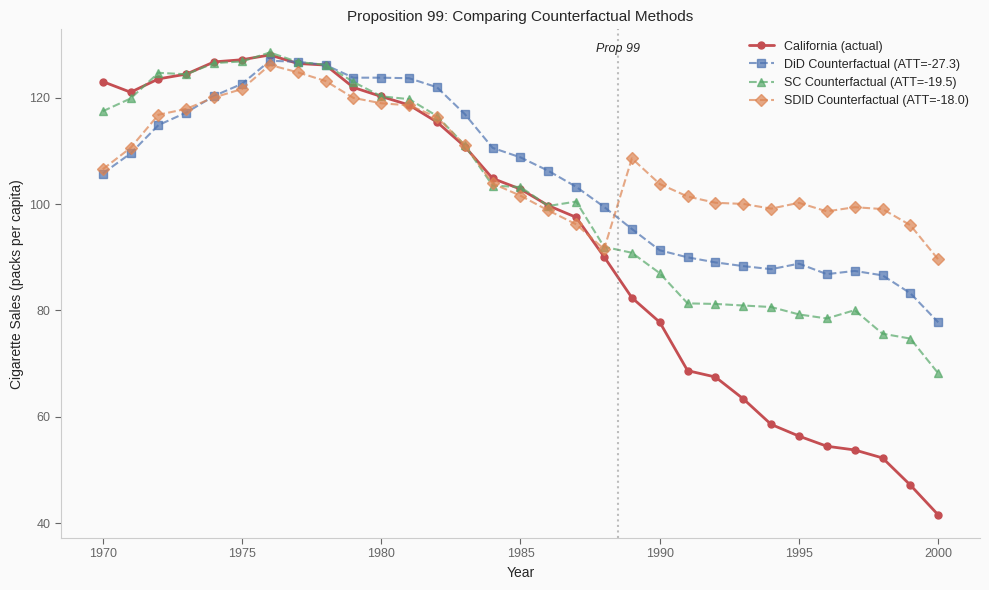

In [16]:
# Visualize all three counterfactuals
fig, ax = plt.subplots(figsize=(10, 6))

# California actual
ax.plot(years, calif_series, 'o-', color=COLORS['red'], 
        label='California (actual)', linewidth=2, markersize=5)

# DiD counterfactual (control mean + parallel shift)
did_shift = Y_tr_pre.mean() - Y_co_pre.mean(axis=0).mean()
did_counterfactual = control_mean + did_shift
ax.plot(years, did_counterfactual, 's--', color=COLORS['blue'], 
        label=f'DiD Counterfactual (ATT={tau_did:.1f})', alpha=0.7)

# SC counterfactual
ax.plot(years, synth_calif, '^--', color=COLORS['green'], 
        label=f'SC Counterfactual (ATT={tau_sc:.1f})', alpha=0.7)

# SDID counterfactual
sdid_pre = w0_sdid + X_sc @ w_sdid
sdid_post = Y_co_post.T @ w_sdid
# Add the pre-period weighted difference
pre_gap = Y_tr_pre.flatten() - sdid_pre
pre_gap_weighted = pre_gap @ lambda_sdid
sdid_counterfactual = np.concatenate([sdid_pre + pre_gap_weighted, sdid_post + pre_gap_weighted])

ax.plot(years, sdid_counterfactual, 'D--', color=COLORS['orange'], 
        label=f'SDID Counterfactual (ATT={tau_sdid:.1f})', alpha=0.7)

ax.axvline(treatment_year - 0.5, color='gray', linestyle=':', alpha=0.5)
ax.text(treatment_year - 0.5, ax.get_ylim()[1] * 0.98, 'Prop 99', 
        ha='center', va='top', fontsize=9, style='italic')

ax.set_xlabel('Year')
ax.set_ylabel('Cigarette Sales (packs per capita)')
ax.set_title('Proposition 99: Comparing Counterfactual Methods')
ax.legend(loc='upper right')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

### Key Insight: Why SDID Differs from SC and DiD

```
★ Insight ─────────────────────────────────────────────────────
SDID typically falls between DiD and SC estimates because:

1. Unit weights (like SC): Emphasize controls with similar trends
2. Time weights (novel): Emphasize pre-periods most predictive of post
3. Fixed effects (like DiD): Model level differences explicitly

The regularization parameter zeta controls sparsity:
- Large zeta → More uniform weights (closer to DiD)
- Small zeta → Sparser weights (closer to SC)
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: What problem does SDID solve that DiD and SC don't?

<details>
<summary>Solution</summary>

**Key points:**

1. **DiD limitation**: Assumes parallel trends hold for ALL control units equally. 
   If some controls have different trends, the estimate is biased.

2. **SC limitation**: Focuses only on matching pre-treatment levels/trends.
   Ignores the change structure that DiD exploits.

3. **SDID solution**: 
   - Unit weights: Find controls most similar to treated (like SC)
   - Time weights: Find pre-periods most predictive of post (novel)
   - Fixed effects: Model level shifts (like DiD)

4. **Practical benefit**: More robust to violations of parallel trends because
   it down-weights controls with dissimilar trends.

</details>

### Q2: Explain the role of the regularization parameter $\zeta$ in SDID.

<details>
<summary>Solution</summary>

**Key points:**

1. **Formula**: $\zeta = (N_{tr} \cdot T_{post})^{1/4} \cdot \hat{\sigma}(\Delta)$

2. **Role**: Controls the L2 penalty on unit weights in the optimization.

3. **Effect**:
   - Large $\zeta$ → Strong penalty → More uniform weights (DiD-like)
   - Small $\zeta$ → Weak penalty → Sparser weights (SC-like)

4. **Why this formula?**:
   - Scales with treatment intensity ($N_{tr} \cdot T_{post}$)
   - Scales with outcome variance ($\sigma(\Delta)$)
   - Ensures good finite-sample properties

5. **Interview insight**: The $1/4$ power comes from optimal rate theory—
   it balances bias from regularization vs variance from noisy weights.

</details>

### Q3: When would you prefer SDID over standard DiD?

<details>
<summary>Solution</summary>

**Prefer SDID when:**

1. **Few treated units**: SC-style weighting helps with limited treatment data
2. **Heterogeneous controls**: Not all controls follow parallel trends
3. **Long pre-period**: Time weights can identify most informative periods
4. **Pre-trends concern**: SDID explicitly addresses this via weighting

**Prefer standard DiD when:**

1. **Many treated units**: Averaging is efficient
2. **Homogeneous controls**: All controls are valid comparisons  
3. **Strong parallel trends**: Visual evidence supports assumption
4. **Simplicity needed**: DiD is easier to interpret and explain

</details>

---

## 6. References {#references}

[^1]: Arkhangelsky, D., Athey, S., Hirshberg, D., Imbens, G., & Wager, S. (2021). 
      Synthetic Difference-in-Differences. *American Economic Review*, 111(12), 4088-4118.

[^2]: Abadie, A., Diamond, A., & Hainmueller, J. (2010). 
      Synthetic Control Methods for Comparative Case Studies. 
      *Journal of the American Statistical Association*, 105(490), 493-505.

[^3]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 25.